Tarea 3

Joaquín Olivares y Benjamín Valdés

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy 
from spacy import displacy
import emoji
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#Carga de los datos
df_train = pd.read_csv("train_tweets.csv")
df_test = pd.read_csv("test_tweets.csv")
df_train.head(5)

,tweet_id,text,Odio
0,1399516036240662528,En una amistad o soy tipo: \r\nLo peor es que ...,0
1,1320788179721560065,QUIEN FUE LA MARACA CULIA TE VOY A MATAR PERRA...,1
2,1079889645280944129,menos mal q se recibe el año con ropa blanca j...,0
3,1369254390134145033,Cuantos INFILTRADOS extranjeros hay ahi😡 https...,1
4,1533854824378290176,#ENCONTRADO #GUAYAQUIL\r\nFecha: 06/06/22\r\nS...,0


Limpieza de datos y preprocesamiento

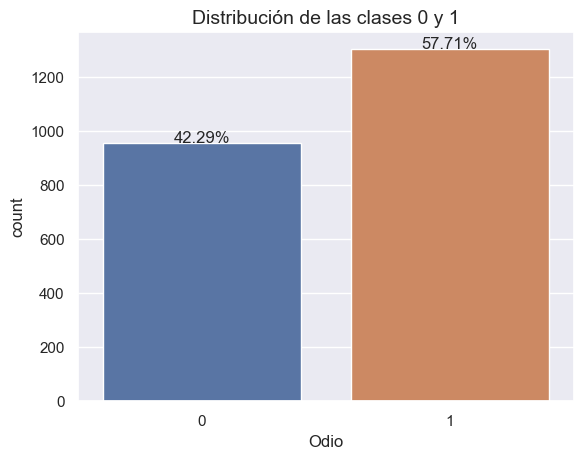

In [3]:
#Revisión de porcentajes por clase en set de train
sns.set(style="darkgrid")
ax = sns.countplot(x='Odio', data=df_train)
plt.title('Distribución de las clases 0 y 1', fontsize=14)

# Añadir porcentajes en cada barra
total = float(len(df_train))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:.2%}'.format(height/total), ha="center")

plt.show()

Se puede ver que la data de train no está completamente balanceada, ya que las clases tienen una diferencia de 15% en la cantidad de datos total; 57.71% para la etiqueta Odio positivo (1) y 42.29% para la etiqueta Odio negativo (0). Esto es algo importante a tener en cuenta, y es lógico evaluar el rendimiento de los modelos usando F1-score, ya que es útil cuando hay desbalanceos entre clases. 

F1-score es una métrica que combina precision y recall, por lo que a mayor F1-score, hay un mejor equilibrio entre ellas y un mejor rendimiento del modelo.

In [4]:
#Revisión de dtypes
print("Set de train:")
print(df_train.dtypes)
print("\nSet de test:")
print(df_test.dtypes)

Set de train:
tweet_id     int64
text        object
Odio         int64
dtype: object

Set de test:
tweet_id     int64
text        object
dtype: object


Los tipos en ambos set son acordes a lo que representa cada variable.

In [5]:
#Análisis de NA train
df_train.isnull().sum()
#No hay datos nulos en set de train

tweet_id    0
text        0
Odio        0
dtype: int64

In [6]:
#Análisis de NA test
df_test.isnull().sum()
#No hay datos nulos en set de test

tweet_id    0
text        0
dtype: int64

Se puede ver que no hay datos nulos en ninguno de los set de datos, por lo que no es necesario hacer un proceso de eliminación o tratamiento de NAs en ningún caso. 

Se realizará una eliminación de emojis debido a la subjetividad en la utilización de estos. Si bien podría ayudar en algo al momento de la predicción, se decide que no se realizará por la subjetividad y porque hay modelos que pueden sufrir con la maldición de la dimensionalidad. Por otro lado, se eliminarán las menciones (@) y los "enter" que se hacen en Windows (\r\n), ya que no sirven para el propósito de este trabajo.

In [7]:
#Revisión de emojis
import emoji 
#función para ver si hay emojis
def revision_emoji(text):
    return emoji.emoji_count(text) > 0

#función para eliminar emojis
def eliminacion_emojis(text):
    #eliminación de emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F700-\U0001F77F" 
                               u"\U0001F780-\U0001F7FF"  
                               u"\U0001F800-\U0001F8FF" 
                               u"\U0001F900-\U0001F9FF"  
                               u"\U0001FA00-\U0001FA6F" 
                               u"\U0001FA70-\U0001FAFF"  
                               u"\U00002702-\U000027B0"  
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#función para eliminar @ y \r\n
def eliminacion_menciones(text):
    # Verificar si el valor es una cadena
    if isinstance(text, str):
        # Eliminar menciones con @
        text_no_mentions = re.sub(r'@\w+', '', text)
        text_no_mentions = text_no_mentions.replace("\r\n", '')
        return text_no_mentions
    else:
        return text  # Devolver el valor original si no es una cadena

A continuación se realiza el preprocesamiento inicial para analizar los tweets de manera preliminar:

In [8]:
#Se eliminarán emojis, menciones y enter para analizar los tweets en sí
#Revisar filas con emoji set de test
df_train['has_emoji'] = df_train['text'].apply(revision_emoji)
#Eliminar emojis set de test
df_train['text_no_emoji'] = df_train['text'].apply(eliminacion_emojis)
#Eliminar @ set de test
df_train['text_no_emoji'] = df_train['text_no_emoji'].apply(eliminacion_menciones)
#Utilizar solo columnas que sirven después de la eliminación:
df_train = df_train.drop(['text', 'has_emoji','tweet_id'], axis=1)

min      4
max    312
Name: text_no_emoji, dtype: int64

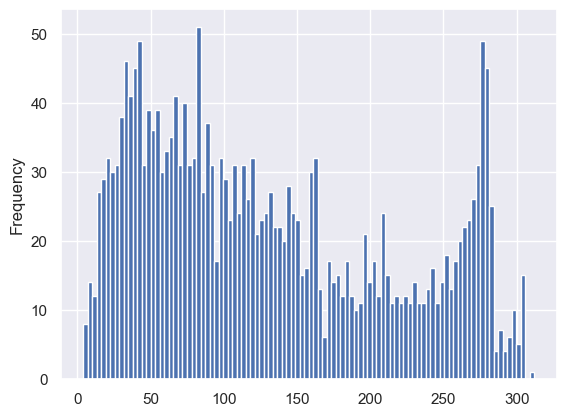

In [9]:
#Cantidad de carácteres
count = df_train.text_no_emoji.str.len()
count.plot(kind="hist", bins=100)
count.agg(["min", "max"])

In [10]:
count.describe(percentiles=[0.25, 0.5, 0.75, 0.95])

count    2256.000000
mean      130.727837
std        85.013725
min         4.000000
25%        58.000000
50%       112.000000
75%       200.250000
95%       279.000000
max       312.000000
Name: text_no_emoji, dtype: float64

Se puede ver que la gran mayoría de los tweets tienen menos de 300 carácteres, sin embargo, no se eliminarán los "outliers" porque son importantes para el estudio también.

<AxesSubplot: ylabel='Frequency'>

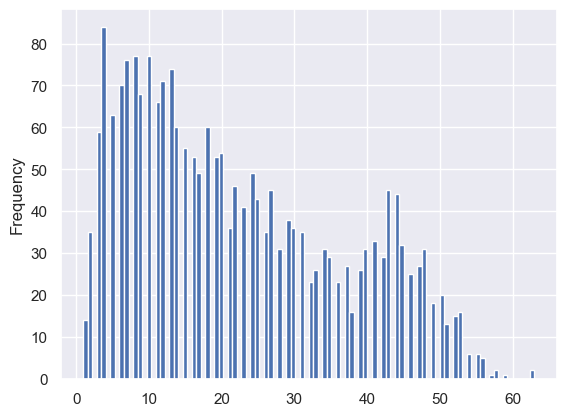

In [11]:
#Cantidad de palabras por tweet
words_count = df_train.text_no_emoji.str.split().apply(len)
words_count.plot(kind="hist", bins=100)

In [12]:
words_count.describe(percentiles=[0.25, 0.5, 0.75,0.95])

count    2256.000000
mean       22.049202
std        14.573364
min         1.000000
25%        10.000000
50%        19.000000
75%        33.000000
95%        48.000000
max        63.000000
Name: text_no_emoji, dtype: float64

Se puede ver que la gran mayoría de los tweets tienen menos de 50 palabras, pero no se eliminarán los "outliers" porque son importantes para el estudio también. Además de esto, el número máximo de palabras no es significativamente mayor.

A continuación se crearán las funciones para trabajar con el módulo Spacy y crear features adicionales (limpiar el texto y determinar la cantidad de tipos de palabras por tweet (por ejemplo, cantidad de adjetivos, sustantivos, etc)):

In [13]:
#función para obtener información de cada token usando spacy
def extract_spacy_info(doc, doc_index=0):
    data_list = []
    for token in doc:
        data = dict()
        data["doc_index"] = doc_index #índice del documento
        data["Text"] = token.text #texto del token
        data["Lemma"] = token.lemma_ #lema del token, palabra original
        data["ent_iob"] = token.ent_iob_ #IOB-BIO
        data["ent_type"] = token.ent_type_ #tipo de entidad del token
        data["POS"] = token.pos_ #etiqueta parte del discurso. qué tipo de palabra es
        data["is_alpha"] = token.is_alpha #si es alfabético o no
        data["is_stop"] = token.is_stop #si es una palabra muy común
        data_list.append(data)
    return data_list

In [14]:
#función para manejar texto con spacy
def spacy_df_create(data_sp):
    nlp = spacy.load("es_core_news_sm")
    data = []
    for idx, text in enumerate(data_sp.text.values):
        doc = nlp(text)
        data.extend(extract_spacy_info(doc, doc_index=idx)) #concatenar las listas
    spacy_df = pd.DataFrame(data) #pasar a dataframe
    return spacy_df

In [15]:
#función para eliminar emojis, @, \r\n y determinar la cantidad de tipos de palabras por tweet
#se agrupa por tipo de palabra
def create_additional_features(clean_text,spacy_df):
    clean_text['has_emoji'] = clean_text['text'].apply(revision_emoji)
    #Eliminar emojis set de test
    clean_text['text_no_emoji'] = clean_text['text'].apply(eliminacion_emojis)
    #Eliminar @ set de test
    clean_text['text_no_emoji'] = clean_text['text_no_emoji'].apply(eliminacion_menciones)
    #Utilizar solo columnas que sirven después de la eliminación:
    clean_text = clean_text.drop(['text', 'has_emoji','tweet_id'], axis=1)
    pd.DataFrame(clean_text)
    pos_df = (
        spacy_df.groupby(["doc_index", "POS"], as_index=False)
        .size()
        .pivot(index="doc_index", columns="POS")
        .fillna(0)
    )
    pos_df.columns = pos_df.columns.droplevel()
    return pd.DataFrame(clean_text).join(pos_df)

A partir de todo esto, se decide que la limpieza de datos y el procesamiento para poder aplicar los modelos es el siguiente:

1. Aplicar la función create_additional_features para quedarse con el texto limpio (sin emojis, menciones (@) ni enter (\r\n)), y columnas que representen la cantidad de cada tipo de palabra en el texto limpio (por ejemplo, cantidad de adjetivos, sustantivos, etc).

2. Aplicar un TfidfVectorizer para pasar el texto limpio a columnas que representen cada una de las palabras.

3. Aplicar estandarización de los datos con StandardScaler.

4. Aplicar el modelo.

Todos estos pasos serán incluidos en un Pipeline por facilidad.

Ahora se procederá a la aplicación de los modelos:

In [16]:
df_train = pd.read_csv("train_tweets.csv")
spacy_df_train=spacy_df_create(df_train)

Modelo 1: SVM

In [17]:
y=df_train["Odio"]
X=df_train.drop(columns="Odio")
ft=FunctionTransformer(create_additional_features,kw_args=dict(spacy_df=spacy_df_train))

prep=ColumnTransformer(transformers=[
    ("tdf",TfidfVectorizer(min_df=3),"text_no_emoji"),],remainder="passthrough")

pipe=Pipeline(steps=[
    ("af",ft),
    ("prep",prep),
    ("sc",StandardScaler(with_mean=False)),
    ("model",SVC(probability=True))
])
pipe

Pipeline(steps=[('af',
                 FunctionTransformer(func=<function create_additional_features at 0x0000016BF3964AF0>,
                                     kw_args={'spacy_df':        doc_index       Text      Lemma ent_iob ent_type    POS  is_alpha  \
0              0         En         en       O             ADP      True   
1              0        una        uno       O             DET      True   
2              0    amistad    amistad       O            NOUN      True   
3              0          o          o       O           CCONJ      True   
4              0        soy        ser       O             AUX      True   
...          ...        ...        ...     ...      ...    ...       ...   
61108       2255       siii       siii       O            NOUN      True   
61109       2255          ?          ?       O           PUNCT     False   
61110       2255          ?          ?       O           PUNCT     False   
61...PER   VERB      True   
61112       2255  respuesta  respuesta       O            NOUN      True   

       is_stop  
0         True  
1         True  
2        False  
3        False  
4         True  
...        ...  
61108    False  
61109    False  
61110    False  
61111    False  
61112    False  

[61113 rows x 8 columns]})),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tdf',
                                                  TfidfVectorizer(min_df=3),
                                                  'text_no_emoji')])),
                ('sc', StandardScaler(with_mean=False)),
                ('model', SVC(probability=True))])

Se decide que por la cantidad de dimensiones que se trabajarán no se probará con el kernel lineal.

In [18]:
#Fit del modelo con kfold
params=dict(model__C=[0.1,1,10,100],prep__tdf__min_df=[1,3,5,10],model__kernel=["rbf","poly"])
search=GridSearchCV(pipe,params,cv=5,scoring="f1",n_jobs=-1,verbose=3)
search.fit(X,y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('af',
                                        FunctionTransformer(func=<function create_additional_features at 0x0000016BF3964AF0>,
                                                            kw_args={'spacy_df':        doc_index       Text      Lemma ent_iob ent_type    POS  is_alpha  \
0              0         En         en       O             ADP      True   
1              0        una        uno       O             DET      True   
2              0    amistad    amistad       O            NOUN      True   
3              0          o          o       O           CCONJ      True   
4              0        soy        ser       O             AUX      True   
...          ...        ...        ...     ...      ...    ...       ...   
61108       2255       siii       siii       O            NOUN      True   
61109       2255          ?          ?       O           PUNCT     F...
61112    False  

[61113 rows x 8 columns]})),
                                       ('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tdf',
                                                                         TfidfVectorizer(min_df=3),
                                                                         'text_no_emoji')])),
                                       ('sc', StandardScaler(with_mean=False)),
                                       ('model', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__kernel': ['rbf', 'poly'],
                         'prep__tdf__min_df': [1, 3, 5, 10]},
             scoring='f1', verbose=3)

In [19]:
#Mejor puntuación del modelo
print("Mejores parámetros:", search.best_params_)
print("F1-score:", search.best_score_)
modelo_svm=search.best_estimator_

Mejores parámetros: {'model__C': 1, 'model__kernel': 'rbf', 'prep__tdf__min_df': 3}
F1-score: 0.7680445481190191


Modelo 2: Naive Bayes

Como se está trabajando con palabras que se "pasan" a números, se decide usar NB multinomial.

In [20]:
df_train = pd.read_csv("train_tweets.csv")
y=df_train["Odio"]
X=df_train.drop(columns="Odio")
ft2=FunctionTransformer(create_additional_features,kw_args=dict(spacy_df=spacy_df_train))

prep2=ColumnTransformer(transformers=[
    ("tdf",TfidfVectorizer(min_df=3),"text_no_emoji"),],remainder="passthrough")

pipe2=Pipeline(steps=[
    ("af",ft2),
    ("prep",prep2),
    ("sc",StandardScaler(with_mean=False)),
    ("model",MultinomialNB())
])
pipe2

Pipeline(steps=[('af',
                 FunctionTransformer(func=<function create_additional_features at 0x0000016BF3964AF0>,
                                     kw_args={'spacy_df':        doc_index       Text      Lemma ent_iob ent_type    POS  is_alpha  \
0              0         En         en       O             ADP      True   
1              0        una        uno       O             DET      True   
2              0    amistad    amistad       O            NOUN      True   
3              0          o          o       O           CCONJ      True   
4              0        soy        ser       O             AUX      True   
...          ...        ...        ...     ...      ...    ...       ...   
61108       2255       siii       siii       O            NOUN      True   
61109       2255          ?          ?       O           PUNCT     False   
61110       2255          ?          ?       O           PUNCT     False   
61...perar       B      PER   VERB      True   
61112       2255  respuesta  respuesta       O            NOUN      True   

       is_stop  
0         True  
1         True  
2        False  
3        False  
4         True  
...        ...  
61108    False  
61109    False  
61110    False  
61111    False  
61112    False  

[61113 rows x 8 columns]})),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tdf',
                                                  TfidfVectorizer(min_df=3),
                                                  'text_no_emoji')])),
                ('sc', StandardScaler(with_mean=False)),
                ('model', MultinomialNB())])

In [21]:
#Fit del modelo con kfold
params2=dict(model__alpha = [0.1,1.0,10,100,300,500,700,1000])
search2=GridSearchCV(pipe2,params2,cv=5,scoring="f1",n_jobs=-1,verbose=3)
search2.fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('af',
                                        FunctionTransformer(func=<function create_additional_features at 0x0000016BF3964AF0>,
                                                            kw_args={'spacy_df':        doc_index       Text      Lemma ent_iob ent_type    POS  is_alpha  \
0              0         En         en       O             ADP      True   
1              0        una        uno       O             DET      True   
2              0    amistad    amistad       O            NOUN      True   
3              0          o          o       O           CCONJ      True   
4              0        soy        ser       O             AUX      True   
...          ...        ...        ...     ...      ...    ...       ...   
61108       2255       siii       siii       O            NOUN      True   
61109       2255          ?          ?       O           PUNCT     F...
61108    False  
61109    False  
61110    False  
61111    False  
61112    False  

[61113 rows x 8 columns]})),
                                       ('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tdf',
                                                                         TfidfVectorizer(min_df=3),
                                                                         'text_no_emoji')])),
                                       ('sc', StandardScaler(with_mean=False)),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 1.0, 10, 100, 300, 500, 700,
                                          1000]},
             scoring='f1', verbose=3)

In [22]:
#Mejor puntuación del modelo
print("Mejores parámetros:", search2.best_params_)
print("F1-score:", search2.best_score_)
modelo_nb=search2.best_estimator_

Mejores parámetros: {'model__alpha': 500}
F1-score: 0.7774722179113999


Modelo 3: Ensamblado

Se probarán dos tipos de ensamblado.

Opción 1: Random forest

In [23]:
df_train = pd.read_csv("train_tweets.csv")
y=df_train["Odio"]
X=df_train.drop(columns="Odio")
ft3=FunctionTransformer(create_additional_features,kw_args=dict(spacy_df=spacy_df_train))

prep3=ColumnTransformer(transformers=[
    ("tdf",TfidfVectorizer(min_df=3),"text_no_emoji"),],remainder="passthrough")

pipe3=Pipeline(steps=[
    ("af",ft3),
    ("prep",prep3),
    ("sc",StandardScaler(with_mean=False)),
    ("model",RandomForestClassifier(random_state=1))
])
pipe3

Pipeline(steps=[('af',
                 FunctionTransformer(func=<function create_additional_features at 0x0000016BF3964AF0>,
                                     kw_args={'spacy_df':        doc_index       Text      Lemma ent_iob ent_type    POS  is_alpha  \
0              0         En         en       O             ADP      True   
1              0        una        uno       O             DET      True   
2              0    amistad    amistad       O            NOUN      True   
3              0          o          o       O           CCONJ      True   
4              0        soy        ser       O             AUX      True   
...          ...        ...        ...     ...      ...    ...       ...   
61108       2255       siii       siii       O            NOUN      True   
61109       2255          ?          ?       O           PUNCT     False   
61110       2255          ?          ?       O           PUNCT     False   
61...
61112       2255  respuesta  respuesta       O            NOUN      True   

       is_stop  
0         True  
1         True  
2        False  
3        False  
4         True  
...        ...  
61108    False  
61109    False  
61110    False  
61111    False  
61112    False  

[61113 rows x 8 columns]})),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tdf',
                                                  TfidfVectorizer(min_df=3),
                                                  'text_no_emoji')])),
                ('sc', StandardScaler(with_mean=False)),
                ('model', RandomForestClassifier(random_state=1))])

In [24]:
#Fit del modelo con kfold
params3=dict(model__n_estimators = [100,200,300,400], model__max_depth=[None,5,10,15],model__min_samples_split=[10, 15,20,30])
search3=GridSearchCV(pipe3,params3,cv=5,scoring="f1",n_jobs=-1,verbose=3)
search3.fit(X,y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('af',
                                        FunctionTransformer(func=<function create_additional_features at 0x0000016BF3964AF0>,
                                                            kw_args={'spacy_df':        doc_index       Text      Lemma ent_iob ent_type    POS  is_alpha  \
0              0         En         en       O             ADP      True   
1              0        una        uno       O             DET      True   
2              0    amistad    amistad       O            NOUN      True   
3              0          o          o       O           CCONJ      True   
4              0        soy        ser       O             AUX      True   
...          ...        ...        ...     ...      ...    ...       ...   
61108       2255       siii       siii       O            NOUN      True   
61109       2255          ?          ?       O           PUNCT     F...
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tdf',
                                                                         TfidfVectorizer(min_df=3),
                                                                         'text_no_emoji')])),
                                       ('sc', StandardScaler(with_mean=False)),
                                       ('model',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 5, 10, 15],
                         'model__min_samples_split': [10, 15, 20, 30],
                         'model__n_estimators': [100, 200, 300, 400]},
             scoring='f1', verbose=3)

In [25]:
#Mejor puntuación del modelo
print("Mejores parámetros:", search3.best_params_)
print("F1-score:", search3.best_score_)
modelo_random_forest=search3.best_estimator_

Mejores parámetros: {'model__max_depth': 15, 'model__min_samples_split': 15, 'model__n_estimators': 400}
F1-score: 0.7904384798262383


Opción 2: Gradient Boosting Classifier

In [26]:
df_train = pd.read_csv("train_tweets.csv")
y=df_train["Odio"]
X=df_train.drop(columns="Odio")
ft5=FunctionTransformer(create_additional_features,kw_args=dict(spacy_df=spacy_df_train))

prep5=ColumnTransformer(transformers=[
    ("tdf",TfidfVectorizer(min_df=3),"text_no_emoji"),],remainder="passthrough")

pipe5=Pipeline(steps=[
    ("af",ft5),
    ("prep",prep5),
    ("sc",StandardScaler(with_mean=False)),
    ("model",GradientBoostingClassifier(random_state=1))
])
pipe5

Pipeline(steps=[('af',
                 FunctionTransformer(func=<function create_additional_features at 0x0000016BF3964AF0>,
                                     kw_args={'spacy_df':        doc_index       Text      Lemma ent_iob ent_type    POS  is_alpha  \
0              0         En         en       O             ADP      True   
1              0        una        uno       O             DET      True   
2              0    amistad    amistad       O            NOUN      True   
3              0          o          o       O           CCONJ      True   
4              0        soy        ser       O             AUX      True   
...          ...        ...        ...     ...      ...    ...       ...   
61108       2255       siii       siii       O            NOUN      True   
61109       2255          ?          ?       O           PUNCT     False   
61110       2255          ?          ?       O           PUNCT     False   
61...
61112       2255  respuesta  respuesta       O            NOUN      True   

       is_stop  
0         True  
1         True  
2        False  
3        False  
4         True  
...        ...  
61108    False  
61109    False  
61110    False  
61111    False  
61112    False  

[61113 rows x 8 columns]})),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tdf',
                                                  TfidfVectorizer(min_df=3),
                                                  'text_no_emoji')])),
                ('sc', StandardScaler(with_mean=False)),
                ('model', GradientBoostingClassifier(random_state=1))])

In [27]:
#Fit del modelo con kfold
params5=dict(model__n_estimators=[50, 100, 200], model__learning_rate=[0.01, 0.1, 1.0])
search5=GridSearchCV(pipe5,params5,cv=5,scoring="f1",n_jobs=-1,verbose=3)
search5.fit(X,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('af',
                                        FunctionTransformer(func=<function create_additional_features at 0x0000016BF3964AF0>,
                                                            kw_args={'spacy_df':        doc_index       Text      Lemma ent_iob ent_type    POS  is_alpha  \
0              0         En         en       O             ADP      True   
1              0        una        uno       O             DET      True   
2              0    amistad    amistad       O            NOUN      True   
3              0          o          o       O           CCONJ      True   
4              0        soy        ser       O             AUX      True   
...          ...        ...        ...     ...      ...    ...       ...   
61108       2255       siii       siii       O            NOUN      True   
61109       2255          ?          ?       O           PUNCT     F...
[61113 rows x 8 columns]})),
                                       ('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tdf',
                                                                         TfidfVectorizer(min_df=3),
                                                                         'text_no_emoji')])),
                                       ('sc', StandardScaler(with_mean=False)),
                                       ('model',
                                        GradientBoostingClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1, 1.0],
                         'model__n_estimators': [50, 100, 200]},
             scoring='f1', verbose=3)

In [28]:
#Mejor puntuación del modelo
print("Mejores parámetros:", search5.best_params_)
print("F1-score:", search5.best_score_)
modelo_gradient_boosting=search5.best_estimator_

Mejores parámetros: {'model__learning_rate': 0.1, 'model__n_estimators': 200}
F1-score: 0.7876112736613231


Comparación y selección del mejor modelo

Para comparar y seleccionar el mejor modelo se tendrán en cuenta dos factores:

1: F1-score.

2: Validación manual de las predicciones hechas por cada modelo. Se realizarán las predicciones del set de test con los cuatro modelos, para luego comparar de manera manual si las predicciones están siendo correctas o no. Para esto, se evaluarán los primeros 5 y los últimos 5 tweets de la data de test, decidiendo si tienen Odio o no según motivos de raza, religión, género u orientación sexual. A partir de esto, se compararán la predicción hecha de forma manual según nuestro criterio y la predicción del modelo, para ver si lo está prediciendo bien o no. Es importante recalcar que se estableció en el trabajo que solo se clasifican como odio los mensajes asociados a raza, religión, género u orientación sexual: " Se considera como discurso de odio los ataques verbales o escritos por motivos de raza, religión, género u orientación sexual".

1: F1-score

In [29]:
#1: F1-Score
print("Modelo SVM:")
print("F1-score:", search.best_score_)
print("Modelo NB:")
print("F1-score:", search2.best_score_)
print("Modelo Random Forest:")
print("F1-score:", search3.best_score_)
print("Modelo Gradient Boosting Classifier:")
print("F1-score:", search5.best_score_)

Modelo SVM:
F1-score: 0.7680445481190191
Modelo NB:
F1-score: 0.7774722179113999
Modelo Random Forest:
F1-score: 0.7904384798262383
Modelo Gradient Boosting Classifier:
F1-score: 0.7876112736613231


Se puede ver que según la métrica F1-score el mejor modelo es el ensamblado Random Forest, ya que tiene el mayor valor de F1. Sin embargo, los modelos no difieren en gran medida en este sentido y todos tienen un F1 bastante similar y bastante alto.

Por otro lado, los tiempos de ejecución son similares y todos menores a 10 minutos de ejecución, por lo que el factor computacional-temporal es "despreciable" para la comparación y selección del mejor modelo en este sentido.

2: Validación manual

Los tweets a evaluar son los siguientes. Se evaluarán con el siguiente esquema: N°, "Tweet" y Explicación.

0. "Estoy de acuerdo que corrijas a tus hijos pero no tratarlos como “Par de hijos de puta”"

- **NO ES ODIO** ya que no está dentro de los marcos establecidos para el trabajo, no hay odio según motivos de raza, religión, género u orientación sexual.

1. "@danieljadue @ArquitectsPC1 Te regalo un pico pa que lleguis de poto, wn hueco."

- **SI ES ODIO** ya que usa una palabra grosera con motivos de burla por su género u orientación sexual.

2. "@Nnicolas_M @carolinawagner_ @i_krmns El paro de camineros no tiene nada que ver con el estado de excepción del gobierno,cuando la ministra habla de evitar el desabastecimiento,se refiere a evitar que estos grupos radicales que dicen ser mapuches corten las rutas,por la cual  se abastece al país."

- **NO ES ODIO** ya que no está dentro de los marcos establecidos para el trabajo, no hay odio según motivos de raza, religión, género u orientación sexual.

3. "@vroteberde Estoy en la misma, hoy no laburo como buen planero-vago-mapuche-iraní."

- **SI ES ODIO** ya que usa una palabra grosera y un contexto denostante con motivos de raza.

4. "@beudalgoaj puta merda"

- **NO ES ODIO** ya que no está dentro de los marcos establecidos para el trabajo, no hay odio según motivos de raza, religión, género u orientación sexual.

2287. "Para variar un veneco pidiendo plata en el metro!!!"

- **SI ES ODIO** ya que usa una palabra grosera (veneco) y un contexto humillante de forma denostante con motivos de raza.

2288. "A mamarla Hijos de puta https://t.co/ZwK27p9TVa"

- **NO ES ODIO** ya que no está dentro de los marcos establecidos para el trabajo, no hay odio según motivos de raza, religión, género u orientación sexual.

2289. "Estamos en el 2022 y algunos colas todavía cuestionan la forma de vestir de otros. Aburrete, hueco culiao."

- **SI ES ODIO** ya que usa una palabra grosera con motivos de burla por su género u orientación sexual.

2290. "@ProfMarcoAvila @_isabelamor @IraciHassler Zopiza!!!!"

- **SI ES ODIO** ya que usa una palabra grosera con motivos de burla por su género u orientación sexual.

2291. "Del avión al estadio! Que puta vergüenza".

- **NO ES ODIO** ya que no está dentro de los marcos establecidos para el trabajo, no hay odio según motivos de raza, religión, género u orientación sexual.

In [30]:
#Modelo 1: SVM
#Predicción a mano, se hacen paso por paso todas las instancias del pipeline con el mejor modelo obtenido
#Set de train
df_train = pd.read_csv("train_tweets.csv")
spacy_df_train = spacy_df_create(df_train)
y = df_train["Odio"]
X = create_additional_features(df_train, spacy_df_train)
tfidf_vectorizer = TfidfVectorizer(min_df=3)
tdv = ColumnTransformer(transformers=[
    ("tfidf", tfidf_vectorizer, "text_no_emoji")
], remainder="passthrough")
X_transformed = tdv.fit_transform(X).toarray()
features_names = tdv.get_feature_names_out()
X_train = pd.DataFrame(X_transformed, columns=features_names)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
modelo=SVC(probability=True,C=1,kernel="rbf")

modelo.fit(X_train_scaled, y)

#Set de test
df_test = pd.read_csv("test_tweets.csv")
spacy_df_test = spacy_df_create(df_test)
X_test = create_additional_features(df_test, spacy_df_test)
X_test["Odio"]=0 #Solo para poder utilizarlo en la función, después se elimina
X_test_transformed = tdv.transform(X_test[['text_no_emoji','PART','AUX','ADV','PRON', 'ADP', 'DET', 'PROPN', 'CCONJ', 'PUNCT', 'Odio', 'SYM', 'VERB', 'INTJ', 'SPACE', 'NOUN', 'NUM', 'ADJ', 'SCONJ']]).toarray()
X_test_transformed = pd.DataFrame(X_test_transformed, columns=features_names)
X_test_scaled = scaler.transform(X_test_transformed)

#Predicción
prediccion = modelo.predict(X_test_scaled)
print(f'Cantidad de predicciones: {prediccion.size}')
print(f'Cantidad sin predecir: {len(prediccion)-prediccion.size}')
#Pasar a CSV
csv_svm = pd.DataFrame({"tweet_id": df_test["tweet_id"], "prediccion": prediccion})
csv_svm

Cantidad de predicciones: 2291
Cantidad sin predecir: 0


,tweet_id,prediccion
0,1533854540763742209,0
1,1277756504519725057,0
2,1529500412402757632,0
3,1167425893066838016,0
4,1399515878727749632,0
...,...,...
2286,1469006079782645762,1
2287,1528569883868508161,0
2288,1502776153001455616,0
2289,1540938860363907073,0


A partir de la comparación con la validación manual, el modelo SVM acierta en 6 predicciones y falla en 4, teniendo una tasa de éxito de 6/10, pero, predice que casi todos son 0.

In [31]:
#Modelo 2: NB
#Predicción a mano, se hacen paso por paso todas las instancias del pipeline con el mejor modelo obtenido
#Set de train
df_train = pd.read_csv("train_tweets.csv")
spacy_df_train = spacy_df_create(df_train)
y = df_train["Odio"]
X = create_additional_features(df_train, spacy_df_train)
tfidf_vectorizer = TfidfVectorizer(min_df=3)
tdv = ColumnTransformer(transformers=[
    ("tfidf", tfidf_vectorizer, "text_no_emoji")
], remainder="passthrough")
X_transformed = tdv.fit_transform(X).toarray()
features_names = tdv.get_feature_names_out()
X_train = pd.DataFrame(X_transformed, columns=features_names)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
modelo=MultinomialNB(alpha=500)

modelo.fit(X_train_scaled, y)

df_test = pd.read_csv("test_tweets.csv")
spacy_df_test = spacy_df_create(df_test)
X_test = create_additional_features(df_test, spacy_df_test)
X_test["Odio"]=0 #Solo para poder utilizarlo en la función, después se elimina
X_test_transformed = tdv.transform(X_test[['text_no_emoji','PART','AUX','ADV','PRON', 'ADP', 'DET', 'PROPN', 'CCONJ', 'PUNCT', 'Odio', 'SYM', 'VERB', 'INTJ', 'SPACE', 'NOUN', 'NUM', 'ADJ', 'SCONJ']]).toarray()
X_test_transformed = pd.DataFrame(X_test_transformed, columns=features_names)
X_test_scaled = scaler.transform(X_test_transformed)

#Predicción
prediccion = modelo.predict(X_test_scaled)
print(f'Cantidad de predicciones: {prediccion.size}')
print(f'Cantidad sin predecir: {len(prediccion)-prediccion.size}')
#Pasar a CSV
csv_nb = pd.DataFrame({"tweet_id": df_test["tweet_id"], "prediccion": prediccion})
csv_nb

Cantidad de predicciones: 2291
Cantidad sin predecir: 0


,tweet_id,prediccion
0,1533854540763742209,0
1,1277756504519725057,1
2,1529500412402757632,1
3,1167425893066838016,0
4,1399515878727749632,0
...,...,...
2286,1469006079782645762,1
2287,1528569883868508161,0
2288,1502776153001455616,1
2289,1540938860363907073,1


A partir de la comparación con la validación manual, el modelo NB acierta en 8 predicciones y falla en 2, teniendo una tasa de éxito de 8/10. Es importante mencionar que las dos fallas que tiene (2 y 3), son las "más" difíciles de clasificar, ya que en la 2 hay una palabra compuesta inventada que es sumamente compleja de interpretar, y en la 3 se utiliza una palabra que puede ser asociada a mensajes de odio de género u orientación sexual (puta).

In [32]:
#Modelo 3: Random Forest
#Predicción a mano, se hacen paso por paso todas las instancias del pipeline con el mejor modelo obtenido
#Set de train
df_train = pd.read_csv("train_tweets.csv")
spacy_df_train = spacy_df_create(df_train)
y = df_train["Odio"]
X = create_additional_features(df_train, spacy_df_train)
tfidf_vectorizer = TfidfVectorizer(min_df=3)
tdv = ColumnTransformer(transformers=[
    ("tfidf", tfidf_vectorizer, "text_no_emoji")
], remainder="passthrough")
X_transformed = tdv.fit_transform(X).toarray()
features_names = tdv.get_feature_names_out()
X_train = pd.DataFrame(X_transformed, columns=features_names)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
modelo = RandomForestClassifier(random_state=1,max_depth=15,min_samples_split=15,n_estimators=400) #igual al obtenido con GridSearchCV

modelo.fit(X_train_scaled, y)

#Set de test
df_test = pd.read_csv("test_tweets.csv")
spacy_df_test = spacy_df_create(df_test)
X_test = create_additional_features(df_test, spacy_df_test)
X_test["Odio"]=0 #Solo para poder utilizarlo en la función, después se elimina
X_test_transformed = tdv.transform(X_test[['text_no_emoji','PART','AUX','ADV','PRON', 'ADP', 'DET', 'PROPN', 'CCONJ', 'PUNCT', 'Odio', 'SYM', 'VERB', 'INTJ', 'SPACE', 'NOUN', 'NUM', 'ADJ', 'SCONJ']]).toarray()
X_test_transformed = pd.DataFrame(X_test_transformed, columns=features_names)
X_test_scaled = scaler.transform(X_test_transformed)

#Predicción
prediccion = modelo.predict(X_test_scaled)
print(f'Cantidad de predicciones: {prediccion.size}')
print(f'Cantidad sin predecir: {len(prediccion)-prediccion.size}')
#Pasar a CSV
csv_rf = pd.DataFrame({"tweet_id": df_test["tweet_id"], "prediccion": prediccion})
csv_rf

Cantidad de predicciones: 2291
Cantidad sin predecir: 0


,tweet_id,prediccion
0,1533854540763742209,0
1,1277756504519725057,0
2,1529500412402757632,1
3,1167425893066838016,1
4,1399515878727749632,0
...,...,...
2286,1469006079782645762,0
2287,1528569883868508161,0
2288,1502776153001455616,0
2289,1540938860363907073,0


A partir de la comparación con la validación manual, el modelo RF acierta en 4 predicciones y falla en 6, teniendo una tasa de éxito de 4/10, pero, predice que casi todos son 0. Es importante destacar que este mal funcionamiento a la hora de comparar la predicción, se podría deber a un sobre entrenamiento del árbol con el set de train, y no puede predecir de buena manera el set de test, porque podrían haber palabras en test que no estén en train, o viceversa.

In [33]:
#Modelo 4: Gradient Boosting
#Predicción a mano, se hacen paso por paso todas las instancias del pipeline con el mejor modelo obtenido
#Set de train
df_train = pd.read_csv("train_tweets.csv")
spacy_df_train = spacy_df_create(df_train)
y = df_train["Odio"]
X = create_additional_features(df_train, spacy_df_train)
tfidf_vectorizer = TfidfVectorizer(min_df=3)
tdv = ColumnTransformer(transformers=[
    ("tfidf", tfidf_vectorizer, "text_no_emoji")
], remainder="passthrough")
X_transformed = tdv.fit_transform(X).toarray()
features_names = tdv.get_feature_names_out()
X_train = pd.DataFrame(X_transformed, columns=features_names)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
modelo=GradientBoostingClassifier(random_state=1,learning_rate=0.1,n_estimators=200)

modelo.fit(X_train_scaled, y)

#Set de test
df_test = pd.read_csv("test_tweets.csv")
spacy_df_test = spacy_df_create(df_test)
X_test = create_additional_features(df_test, spacy_df_test)
X_test["Odio"]=0 #Solo para poder utilizarlo en la función, después se elimina
X_test_transformed = tdv.transform(X_test[['text_no_emoji','PART','AUX','ADV','PRON', 'ADP', 'DET', 'PROPN', 'CCONJ', 'PUNCT', 'Odio', 'SYM', 'VERB', 'INTJ', 'SPACE', 'NOUN', 'NUM', 'ADJ', 'SCONJ']]).toarray()
X_test_transformed = pd.DataFrame(X_test_transformed, columns=features_names)
X_test_scaled = scaler.transform(X_test_transformed)

#Predicción
prediccion = modelo.predict(X_test_scaled)
print(f'Cantidad de predicciones: {prediccion.size}')
print(f'Cantidad sin predecir: {len(prediccion)-prediccion.size}')
#Pasar a CSV
csv_gb = pd.DataFrame({"tweet_id": df_test["tweet_id"], "prediccion": prediccion})
csv_gb

Cantidad de predicciones: 2291
Cantidad sin predecir: 0


,tweet_id,prediccion
0,1533854540763742209,0
1,1277756504519725057,0
2,1529500412402757632,0
3,1167425893066838016,0
4,1399515878727749632,0
...,...,...
2286,1469006079782645762,0
2287,1528569883868508161,0
2288,1502776153001455616,0
2289,1540938860363907073,0


A partir de la comparación con la validación manual, el modelo GB acierta en 5 predicciones y falla en 5, teniendo una tasa de éxito de 5/10, pero, predice todos son 0. Es importante destacar que al revisar toda la predicción en este caso, todas son 0, por lo que claramente el modelo no es un buen predictor, ya que a todo le asigna 0.

A partir de todo esto, y teniendo en cuenta que el F1-score es bastante similar para todos los modelos, que SVM tiene una tasa de éxito de 6/10, que puede ser que RF esté sobre entrenado, que GB claramente no es un buen predictor, y que NB tiene una tasa de éxito de 8/10 en la validación manual y solo se equivoca en los dos casos más complejos estudiados, se decide que el mejor modelo para predecir es el modelo Naive Bayes.

Predicción final

In [34]:
csv_nb.to_csv('Tarea3_Olivares_Valdes.csv', index=False, float_format='%.2f')

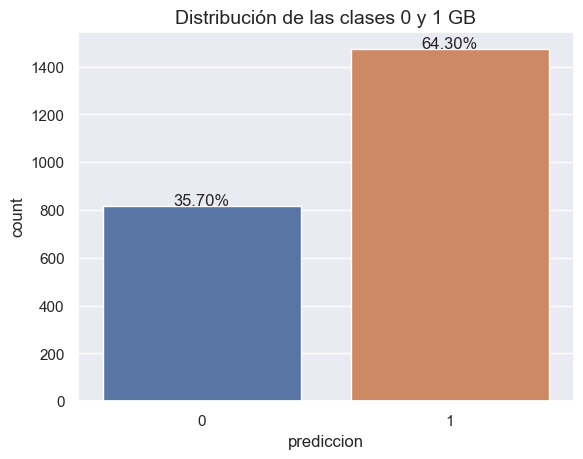

In [35]:
#Revisión de porcentajes por clase en set de test
sns.set(style="darkgrid")
ax = sns.countplot(x='prediccion', data=csv_nb)
plt.title('Distribución de las clases 0 y 1 GB', fontsize=14)

# Añadir porcentajes en cada barra
total = float(len(csv_nb))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:.2%}'.format(height/total), ha="center")

plt.show()

Finalmente se puede ver que la predicción hecha por el modelo NB es de un 64.3% para la clase Odio positiva y 35.7% para la clase Odio negativa.